<a href="https://colab.research.google.com/github/ANGB022210151/AquacultureProject/blob/main/dbscan_step4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# 1. Load your data into a Pandas DataFrame from the CSV file
df = pd.read_csv('/content/full_dataset_with_normal_inliers.csv')

# Display the first 5 rows to verify the data is loaded correctly
display(df.head())

,time,temperature_cleaned,tds_cleaned,turbidity_cleaned,pH_cleaned,Rate of Change (ΔT/Δt),Moving Average Deviation,Short-Term Gradient (ΔNTU),Rolling Variance (σ²ₚₕ),temp_fault,tds_fault,turbidity_fault,ph_fault,fault detection,anomaly_label_overall,anomaly_description_overall
0,2025-12-03 22:45:00+08:00,28.0,252.1596,4,7.535385,NaN,NaN,NaN,NaN,False,False,False,False,['normal'],1.0,Inlier
1,2025-12-03 23:00:00+08:00,28.0,252.1596,4,7.535385,0.0,NaN,0.0,NaN,False,False,False,False,['normal'],1.0,Inlier
2,2025-12-03 23:15:00+08:00,28.0,252.1596,4,7.535385,0.0,NaN,0.0,NaN,False,False,False,False,['normal'],1.0,Inlier
3,2025-12-03 23:30:00+08:00,28.0,252.1596,4,7.535385,0.0,NaN,0.0,NaN,False,False,False,False,['normal'],1.0,Inlier
4,2025-12-03 23:45:00+08:00,28.0,252.1596,4,7.535385,0.0,0.0,0.0,0.0,False,False,False,False,['normal'],1.0,Inlier


## Perform DBSCAN Clustering

### Subtask:
Apply DBSCAN to the scaled outlier data (`X_scaled`) using previously determined `eps` and `min_samples` values. This will initially categorize points into density-based clusters and noise (-1).


**Reasoning**:
To apply DBSCAN clustering, I need to import the `DBSCAN` class, instantiate it with the given `eps_chosen` and `min_samples_chosen` values, and then fit the model to the `X_scaled` data.



## Separate Noise and Clustered Points

### Subtask:
Based on the DBSCAN results, create two subsets: one containing the points identified as noise (-1), and another containing all points that were part of a DBSCAN-identified cluster (labels >= 0).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assume `df` is already loaded from cell X0j0WgCTQaHJ.

# 1. Identify numerical features for scaling. `core_features` are prioritized.
core_features = ['temperature_cleaned', 'tds_cleaned', 'turbidity_cleaned', 'pH_cleaned']

# --- DIAGNOSTIC ADDITION ---
print("Value counts for 'anomaly_description_overall' before filtering:")
print(df['anomaly_description_overall'].value_counts())
# ---------------------------

# 2. Create `df_outliers` by filtering `df` based on 'anomaly_description_overall' column.
df_outliers = df[df['anomaly_description_overall'] == 'Outlier'].copy() # Changed 'outlier' to 'Outlier'

# Get all numerical columns from the new `df_outliers`.
all_numerical_cols_outliers = df_outliers.select_dtypes(include=np.number).columns.tolist()

# 3. Select 8 features for `X_scaled` from `df_outliers`.
# These should ideally include the `core_features` and then other relevant numerical features.
selected_features_for_X_scaled = [col for col in core_features if col in df_outliers.columns]

# Add other numerical columns until we have 8 features for X_scaled, if available.
other_numerical_outlier_cols = [col for col in all_numerical_cols_outliers if col not in selected_features_for_X_scaled]
num_to_add_to_X_scaled = 8 - len(selected_features_for_X_scaled)

if num_to_add_to_X_scaled > 0 and len(other_numerical_outlier_cols) > 0:
    selected_features_for_X_scaled.extend(other_numerical_outlier_cols[:num_to_add_to_X_scaled])

# Fallback if still not 8 features (unlikely but for robustness).
# If after prioritizing core_features and adding others, we still don't have 8, or if no core_features were present,
# take from the available numerical columns.
if len(selected_features_for_X_scaled) == 0 and len(df_outliers.columns) > 0:
    selected_features_for_X_scaled = df_outliers.columns[:min(8, len(df_outliers.columns))].tolist()
elif len(selected_features_for_X_scaled) < 8 and len(df_outliers.columns) > len(selected_features_for_X_scaled):
    # If still less than 8, and df_outliers has more, take more from df_outliers. Filter out already selected.
    available_for_x_scaled = [col for col in df_outliers.columns if col not in selected_features_for_X_scaled]
    selected_features_for_X_scaled.extend(available_for_x_scaled[:(8 - len(selected_features_for_X_scaled))])

# Ensure we have at least 8 features if possible, or all numerical features if less than 8 are available.
if len(selected_features_for_X_scaled) > 8:
    selected_features_for_X_scaled = selected_features_for_X_scaled[:8]
elif len(selected_features_for_X_scaled) == 0 and len(all_numerical_cols_outliers) > 0:
    selected_features_for_X_scaled = all_numerical_cols_outliers[:min(8, len(all_numerical_cols_outliers))]


# 4. Scale the selected features to create `X_scaled`.
# Check if selected_features_for_X_scaled is not empty before scaling
if not selected_features_for_X_scaled:
    raise ValueError("No numerical features available for X_scaled after filtering for outliers.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_outliers[selected_features_for_X_scaled])

print(f"Shape of df_outliers: {df_outliers.shape}")
print(f"Shape of X_scaled: {X_scaled.shape}")

Value counts for 'anomaly_description_overall' before filtering:
anomaly_description_overall
Inlier     920
Outlier    394
Name: count, dtype: int64
Shape of df_outliers: (394, 16)
Shape of X_scaled: (394, 8)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Assuming X_scaled contains your Isolation Forest Outliers
results = []

# Range based on your previous testing
for eps in np.arange(0.8, 2.1, 0.1):
    for min_samples in [4, 6, 8, 10, 12, 14, 16]:
        dbsc = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbsc.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        results.append({
            'eps': round(eps, 2),
            'min_samples': min_samples,
            'clusters': n_clusters,
            'noise': n_noise
        })

# Create results DataFrame
results_df = pd.DataFrame(results)

# --- THE MODIFICATION: Show only 3 clusters ---
three_cluster_results = results_df[results_df['clusters'] == 3].copy()

# Sort by noise amount (lowest noise first is usually better)
three_cluster_results = three_cluster_results.sort_values(by='noise')

print("--- Parameter Options for Exactly 3 Clusters ---")
if not three_cluster_results.empty:
    print(three_cluster_results.to_string(index=False))
else:
    print("No configurations found with exactly 3 clusters. Try expanding the eps range.")

--- Parameter Options for Exactly 3 Clusters ---
 eps  min_samples  clusters  noise
 1.4           14         3     35
 1.4           16         3     41
 1.3           12         3     49
 1.2           10         3     57
 1.3           14         3     59
 1.3           16         3     62
 1.2           12         3     67
 1.2           14         3     72
 1.1            8         3     77
 1.2           16         3     83
 1.1           10         3     88
 1.0            8         3     97
 1.1           12         3    101
 1.1           14         3    114
 1.0           10         3    129
 1.1           16         3    130
 1.0           12         3    158
 1.0           14         3    195
 0.9           10         3    203
 0.9           12         3    251


In [ ]:
for trial_eps in [0.9, 1.1, 1.3, 1.5]:
    for trial_min in [8, 10, 12]:
        dbsc = DBSCAN(eps=trial_eps, min_samples=trial_min)
        labels = dbsc.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        print(f"Eps: {trial_eps} | MinSamples: {trial_min} | Clusters: {n_clusters} | Noise: {n_noise}")

Eps: 0.9 | MinSamples: 8 | Clusters: 4 | Noise: 156
Eps: 0.9 | MinSamples: 10 | Clusters: 3 | Noise: 203
Eps: 0.9 | MinSamples: 12 | Clusters: 3 | Noise: 251
Eps: 1.1 | MinSamples: 8 | Clusters: 3 | Noise: 77
Eps: 1.1 | MinSamples: 10 | Clusters: 3 | Noise: 88
Eps: 1.1 | MinSamples: 12 | Clusters: 3 | Noise: 101
Eps: 1.3 | MinSamples: 8 | Clusters: 2 | Noise: 28
Eps: 1.3 | MinSamples: 10 | Clusters: 4 | Noise: 40
Eps: 1.3 | MinSamples: 12 | Clusters: 3 | Noise: 49
Eps: 1.5 | MinSamples: 8 | Clusters: 1 | Noise: 19
Eps: 1.5 | MinSamples: 10 | Clusters: 1 | Noise: 22
Eps: 1.5 | MinSamples: 12 | Clusters: 1 | Noise: 22


In [ ]:
from sklearn.cluster import DBSCAN

# Instantiate DBSCAN with the chosen parameters
dbsc = DBSCAN(eps=1.4, min_samples=14)

# Fit the model to the scaled outlier data and get cluster labels
clusters = dbsc.fit_predict(X_scaled)

print(f"DBSCAN clustering performed. Number of clusters found: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(f"Number of noise points (-1 label): {list(clusters).count(-1)}")

DBSCAN clustering performed. Number of clusters found: 3
Number of noise points (-1 label): 35


**Reasoning**:
To separate the noise and clustered points based on DBSCAN results, I will create boolean masks from the `clusters` array and apply them to `X_scaled` and `df_outliers` to generate the required DataFrames.



In [ ]:
import numpy as np
import pandas as pd # Added pandas import

# 1. Create a boolean mask for noise points
noise_mask = (clusters == -1)

# 2. Create X_scaled_noise DataFrame
X_scaled_noise = X_scaled[noise_mask]

# 3. Create df_noise DataFrame from original df_outliers
df_noise = df_outliers[noise_mask].copy() # Ensure df_noise is a copy

# 4. Create a boolean mask for clustered points
clustered_mask = (clusters != -1)

# 5. Create X_scaled_clustered DataFrame
X_scaled_clustered = X_scaled[clustered_mask]

# 6. Create df_clustered DataFrame from original df_outliers
df_clustered = df_outliers[clustered_mask].copy() # Ensure df_clustered is a copy

print(f"Shape of X_scaled_noise: {X_scaled_noise.shape}")
print(f"Shape of df_noise: {df_noise.shape}")
print(f"Shape of X_scaled_clustered: {X_scaled_clustered.shape}")
print(f"Shape of df_clustered: {df_clustered.shape}")

# Convert NumPy arrays to DataFrame for display with .head()
display(pd.DataFrame(X_scaled_noise).head())
display(df_noise.head())
display(pd.DataFrame(X_scaled_clustered).head())
display(df_clustered.head())

Shape of X_scaled_noise: (35, 8)
Shape of df_noise: (35, 16)
Shape of X_scaled_clustered: (359, 8)
Shape of df_clustered: (359, 16)


,0,1,2,3,4,5,6,7
0,-1.194864,0.643934,-0.574717,-0.608509,-2.161422,0.291971,0.017057,-0.589519
1,-1.565177,1.172708,-0.574717,-0.636707,-2.389455,1.792861,0.017057,-0.549996
2,-0.959209,0.966700,-0.630257,-0.580313,2.969319,-0.291977,-0.262970,-0.586600
3,-1.868162,1.451691,-0.630257,-0.608509,-3.073555,1.024279,0.017057,-0.589519
4,-1.262193,1.096681,-0.630257,-0.589711,2.057187,-0.568567,0.017057,-0.583905


,time,temperature_cleaned,tds_cleaned,turbidity_cleaned,pH_cleaned,Rate of Change (ΔT/Δt),Moving Average Deviation,Short-Term Gradient (ΔNTU),Rolling Variance (σ²ₚₕ),temp_fault,tds_fault,turbidity_fault,ph_fault,fault detection,anomaly_label_overall,anomaly_description_overall
41,2025-12-04 09:00:00+08:00,26.8125,253.4938,4,7.530550,-0.001319,1.06736,0.0,0.000005,False,False,False,False,[],-1.0,Outlier
136,2025-12-05 08:30:00+08:00,26.1250,258.5891,4,7.516044,-0.001458,6.54240,0.0,0.002473,False,False,False,False,[],-1.0,Outlier
659,2025-12-11 18:00:00+08:00,27.2500,256.6040,3,7.545055,0.001806,-1.06280,-1.0,0.000187,False,False,False,False,[],-1.0,Outlier
1107,2025-12-18 08:45:00+08:00,25.5625,261.2774,3,7.530550,-0.001875,3.73872,0.0,0.000005,False,False,False,False,[],-1.0,Outlier
1144,2025-12-18 18:00:00+08:00,26.6875,257.8565,3,7.540220,0.001250,-2.07176,0.0,0.000355,False,False,False,False,[],-1.0,Outlier


,0,1,2,3,4,5,6,7
0,-1.699837,1.095955,-0.574717,-0.617909,-0.565192,1.281000,0.017057,-0.589519
1,-0.721142,0.172509,-0.685798,-0.758670,-0.779246,-1.191913,-0.823024,-0.579368
2,-0.328635,1.098277,-0.574717,-0.499633,1.176533,1.247562,0.297085,-0.552820
3,-0.619640,0.434416,-0.574717,-0.811063,-1.059601,-0.389007,0.297085,-0.475545
4,-0.639066,1.071232,-0.574717,-0.811182,-0.804416,1.314184,-0.262970,-0.574897


,time,temperature_cleaned,tds_cleaned,turbidity_cleaned,pH_cleaned,Rate of Change (ΔT/Δt),Moving Average Deviation,Short-Term Gradient (ΔNTU),Rolling Variance (σ²ₚₕ),temp_fault,tds_fault,turbidity_fault,ph_fault,fault detection,anomaly_label_overall,anomaly_description_overall
426,2025-12-08 08:30:00+08:00,25.875000,257.849500,4,7.525714,-0.000347,4.675200,0.0,0.000005,False,False,False,False,[],-1.0,Outlier
1652,2026-01-01 08:00:00+08:00,27.691980,248.951121,2,7.453302,-0.000478,-4.345640,-3.0,0.000639,False,False,False,False,[],-1.0,Outlier
1679,2026-01-01 14:45:00+08:00,28.420682,257.871884,4,7.586560,0.000714,4.553224,1.0,0.002297,False,False,False,False,[],-1.0,Outlier
1762,2026-01-02 11:30:00+08:00,27.880422,251.474877,4,7.426349,-0.000648,-1.416752,1.0,0.007124,False,False,False,False,[],-1.0,Outlier
1851,2026-01-03 09:45:00+08:00,27.844357,257.611270,4,7.426288,-0.000493,4.796252,-1.0,0.000918,False,False,False,False,[],-1.0,Outlier


## Apply K-Means to DBSCAN Clustered Points

### Subtask:
Apply K-Means clustering with `n_clusters=3` to the subset of points that were identified as non-noise by DBSCAN. This step will create your desired three distinct clusters (Cluster 1, Cluster 2, Cluster 3).


**Reasoning**:
To apply K-Means clustering as specified in the subtask, I need to import the KMeans class, instantiate it with the given parameters, fit it to the `X_scaled_clustered` data, assign the resulting labels to the `df_clustered` DataFrame, and then display the value counts.



In [ ]:
from sklearn.cluster import KMeans

# Instantiate KMeans with n_clusters=3 and random_state for reproducibility
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')

# Fit KMeans to the scaled clustered data and get cluster labels
kmeans_labels = kmeans.fit_predict(X_scaled_clustered)

# Add these K-Means cluster labels as a new column to df_clustered
df_clustered.loc[:, 'kmeans_label'] = kmeans_labels

# Print the value counts of the new kmeans_label column
print("K-Means cluster distribution in df_clustered:")
print(df_clustered['kmeans_label'].value_counts())

K-Means cluster distribution in df_clustered:
kmeans_label
2    139
1    128
0     92
Name: count, dtype: int64


**Reasoning**:
To export the final clustering results, I will save the `cluster_data` DataFrame, which contains the `final_cluster_label` column (including noise and the three K-Means clusters), to a CSV file. This allows for easy access and further analysis of the clustered outlier data.

In [ ]:
import pandas as pd

# Initialize cluster_data as a copy of df_outliers to ensure correct indexing and avoid SettingWithCopyWarning
cluster_data = df_outliers.copy()

# Initialize 'final_cluster_label' column in cluster_data with -1 (DBSCAN noise)
cluster_data['final_cluster_label'] = -1

# Assign K-Means labels to the points that were clustered by DBSCAN
# The indices of df_clustered match the original indices in df_outliers (and now cluster_data)
cluster_data.loc[df_clustered.index, 'final_cluster_label'] = df_clustered['kmeans_label']

# Display the value counts of the final cluster labels (optional, can be removed if not needed here)
print("Distribution of final_cluster_label:")
print(cluster_data['final_cluster_label'].value_counts().sort_index())

output_filename = '/content/clustered_outliers_with_labels.csv'
cluster_data.to_csv(output_filename, index=False)

print(f"Clustered data exported successfully to: {output_filename}")

Distribution of final_cluster_label:
final_cluster_label
-1     35
 0     92
 1    128
 2    139
Name: count, dtype: int64
Clustered data exported successfully to: /content/clustered_outliers_with_labels.csv


**Reasoning**:
To integrate the DBSCAN noise labels and K-Means cluster labels, I will initialize a new `final_cluster_label` column in `cluster_data` with the DBSCAN noise label (-1) for all points. Then, I will update this column for the non-noise points using the `kmeans_label` from the `df_clustered` DataFrame, ensuring the K-Means labels (0, 1, 2) are distinct from the noise label.



In [ ]:
import pandas as pd

# Initialize cluster_data as a copy of df_outliers to ensure correct indexing and avoid SettingWithCopyWarning
cluster_data = df_outliers.copy()

# Initialize 'final_cluster_label' column in cluster_data with -1 (DBSCAN noise)
cluster_data['final_cluster_label'] = -1

# Assign K-Means labels to the points that were clustered by DBSCAN
# The indices of df_clustered match the original indices in df_outliers (and now cluster_data)
cluster_data.loc[df_clustered.index, 'final_cluster_label'] = df_clustered['kmeans_label']

# Display the value counts of the final cluster labels
print("Distribution of final_cluster_label:")
print(cluster_data['final_cluster_label'].value_counts().sort_index())

Distribution of final_cluster_label:
final_cluster_label
-1     35
 0     92
 1    128
 2    139
Name: count, dtype: int64


**Reasoning**:
Now that the final cluster labels are integrated into `cluster_data`, I will provide a summary of the final clusters by calculating descriptive statistics for each cluster. This will help understand the characteristics of the data points within each cluster (including noise).



In [ ]:
print("Descriptive statistics for each final cluster:")
print(cluster_data.groupby('final_cluster_label')[['temperature_cleaned', 'tds_cleaned', 'turbidity_cleaned', 'pH_cleaned']].describe())

Descriptive statistics for each final cluster:
                    temperature_cleaned                                  \
                                  count       mean       std        min   
final_cluster_label                                                       
-1                                 35.0  28.885497  1.846305  25.187500   
 0                                 92.0  31.977854  1.252828  29.233510   
 1                                128.0  28.001230  0.310203  27.218732   
 2                                139.0  28.064922  0.398586  25.875000   

                                                                tds_cleaned  \
                           25%        50%        75%        max       count   
final_cluster_label                                                           
-1                   27.770357  28.538504  30.559439  33.022615        35.0   
 0                   31.170783  32.033288  33.042787  33.984956        92.0   
 1                   27.794908  

**Reasoning**:
To visualize the final clusters, I will create a scatter plot of `temperature_cleaned` versus `tds_cleaned`, coloring the points according to their `final_cluster_label`. This will help in understanding the spatial separation and characteristics of each cluster, including the noise points.



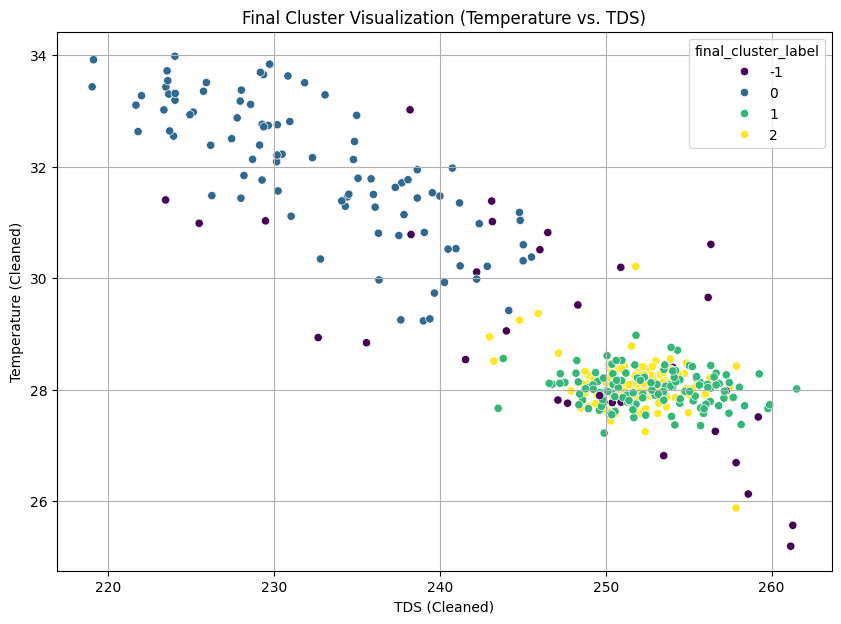

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(data=cluster_data, x='tds_cleaned', y='temperature_cleaned', hue='final_cluster_label', palette='viridis', legend='full')
plt.title('Final Cluster Visualization (Temperature vs. TDS)')
plt.xlabel('TDS (Cleaned)')
plt.ylabel('Temperature (Cleaned)')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import ast

# 1. Load the file that still has your sensor faults
df = pd.read_csv('full_dataset_with_normal_inliers.csv')

# 2. Safe parse to convert the strings back into Python lists
def safe_parse(val):
    if isinstance(val, list): return val
    if pd.isna(val) or val == "" or val == "[]": return []
    try:
        # This converts strings like "['Temperature']" into real lists
        return ast.literal_eval(val)
    except:
        return [val]

df['fault detection'] = df['fault detection'].apply(safe_parse)

# 3. PRIORITY: Only update the Outliers with DBSCAN clusters
label_map = {
    0: 'Pump Degradation',
    1: 'Aeration Inefficiency',
    2: 'Filter Clogging',
    -1: 'Unknown/Noise'
}

# cluster_data contains only the 394 outliers
for idx, row in cluster_data.iterrows():
    new_label = label_map[row['final_cluster_label']]
    # We update the row index found in cluster_data
    df.at[idx, 'fault detection'] = [new_label]

# 4. Standardize 'normal' to 'Normal' (Optional - ONLY for the 920 inlier rows)
# This ignores your sensor faults (NaNs) and updates only the healthy data
mask_normal = (df['fault detection'].apply(lambda x: x == ['normal']))
df.loc[mask_normal, 'fault detection'] = df.loc[mask_normal, 'fault detection'].apply(lambda x: ['Normal'])

# 5. Final distribution check
print("FINAL DISTRIBUTION:")
print(df['fault detection'].astype(str).value_counts())

df.to_csv('labeled_FIXED_final.csv', index=False)

FINAL DISTRIBUTION:
fault detection
['Temperature', 'TDS']       1085
['Normal']                    920
['Filter Clogging']           139
['Aeration Inefficiency']     128
['Pump Degradation']           92
['pH']                         50
['Temperature']                50
['TDS']                        50
['Turbidity']                  50
['Unknown/Noise']              35
Name: count, dtype: int64
